In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import pygenstability as pgs
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.sparse import csr_array, csr_matrix
from scipy.sparse.csgraph import shortest_path
from pygenstability import plotting

c:\Users\SBH\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# read the data from "Data/testforBetween.csv"
data = pd.read_csv("Data/testforBetween.csv", index_col=0)

In [3]:
data

,1,2,3,4,5,6,7,8,9
1,0.0,1.0,1.000,0.500,1.00,1.000,1.00,1.000,0.000
2,1.0,0.0,0.500,1.000,1.00,0.000,1.00,0.000,0.000
3,1.0,0.5,0.000,0.333,1.00,0.000,1.00,0.000,0.000
4,0.5,1.0,0.333,0.000,1.00,1.000,1.00,0.000,0.000
5,1.0,1.0,1.000,1.000,0.00,0.000,0.25,0.500,1.000
6,1.0,0.0,0.000,1.000,0.00,0.000,0.00,0.500,0.333
7,1.0,1.0,1.000,1.000,0.25,0.000,0.00,0.500,1.000
8,1.0,0.0,0.000,0.000,0.50,0.500,0.50,0.000,0.333
9,0.0,0.0,0.000,0.000,1.00,0.333,1.00,0.333,0.000


In [4]:
# convert the data to a numpy matrix
data = data.to_numpy()

In [5]:

# calculate the betweenness centrality while treating the data as a distance matrix by using the networkx library
G = nx.from_numpy_array(data)
# assign each node as a name from 1 to 9
G = nx.relabel_nodes(G, {i: i+1 for i in range(9)})
betweenness = nx.betweenness_centrality(G, weight='weight')
betweenness

{1: 0.008928571428571428,
 2: 0.0,
 3: 0.07142857142857142,
 4: 0.14285714285714285,
 5: 0.0625,
 6: 0.09821428571428571,
 7: 0.0625,
 8: 0.19642857142857142,
 9: 0.0}

In [7]:
# run the greedy modularity algorithm on the graph G
# the result is a dictionary where the keys are the communities and the values are the nodes in each community
communities = nx.algorithms.community.greedy_modularity_communities(G)
communities

[frozenset({1, 2, 3, 4, 5, 7}), frozenset({6, 8, 9})]

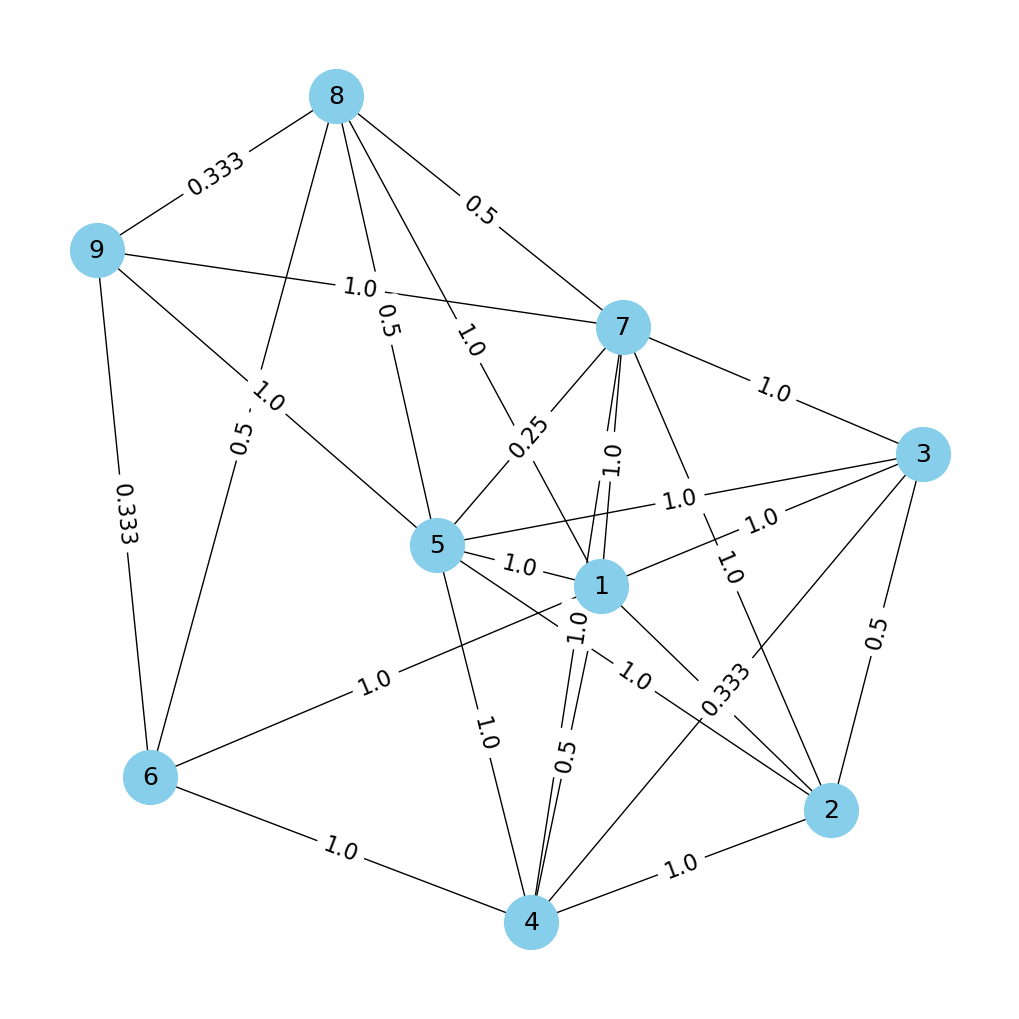

In [9]:
# plot the graph G 
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1500, node_color='skyblue', font_size=18, font_color='black')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d['weight']}" for u, v, d in G.edges(data=True)}, font_size=16)
plt.show()

In [17]:
adjacency_raw = nx.to_numpy_array(G)

In [20]:
#run the community detection onto the G graph
all_results = pgs.run(sp.sparse.csgraph.csgraph_from_dense(adjacency_raw), constructor='linearized', 
                    min_scale=-2, max_scale=2, n_scale=300, method='leiden', n_workers=8,
                    log_scale=True, n_tries=400, n_NVI=20, with_spectral_gap=False)

100%|██████████| 300/300 [00:01<00:00, 274.57it/s]


In [21]:
number_of_communities = all_results['number_of_communities']
number_of_communities = pd.Series(number_of_communities)
number_of_communities.value_counts()

9    168
1    132
Name: count, dtype: int64

In [142]:
# generate a random directed graph with 10 nodes, and as a fully connected graph with random weights
G = nx.fast_gnp_random_graph(15, 0.8, directed=True)
for (u, v) in G.edges():
    G.edges[u, v]['weight'] = np.random.rand()


In [94]:
num = 8
# create a directed graph
G = nx.DiGraph()

# add 20 nodes in the graph
G.add_nodes_from(range(num))

# for each node pair, add an edge with a random weight which belong to a exponential distribution, to make the graph as afull connected graph
for i in range(num):
    for j in range(num):
        if i != j:
            G.add_edge(i, j, weight=np.random.exponential(1))


In [143]:
adjacency_raw = nx.to_numpy_array(G)

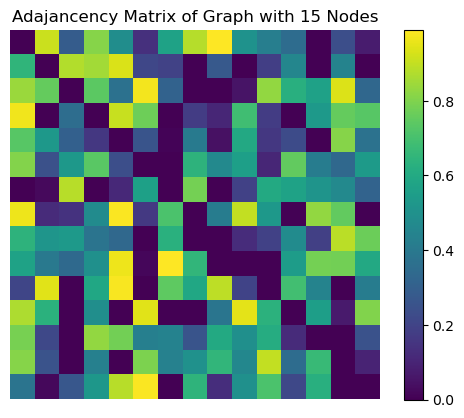

In [145]:
# plot the adajacency_raw matrix as a heatmap
plt.figure()
plt.imshow(adjacency_raw, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Adajancency Matrix of Graph with 15 Nodes')
# dont show the axis
plt.axis('off')
plt.show()


In [150]:
# use the greedy modularity algorithm to find the community structure of the graph
communities = nx.community.greedy_modularity_communities(G)
communities

[frozenset({0, 1, 2, 4, 6, 8, 10, 11, 14}), frozenset({3, 5, 7, 9, 12, 13})]

In [ ]:

# plot each node in the graph with a color that represents the community it belongs to
plt.figure()
pos = nx.spring_layout(G)
colors = np.zeros(num)
for i, community in enumerate(communities):
    for node in community:
        colors[node] = i
nx.draw(G, pos, node_color=colors, with_labels=True)
plt.title('Community Structure of the Graph')
plt.show()


In [136]:
all_results = pgs.run(sp.sparse.csgraph.csgraph_from_dense(adjacency_raw), constructor='linearized_directed', 
                    min_scale=-2, max_scale=2, n_scale=300, method='leiden', n_workers=8,
                    log_scale=True, n_tries=400, n_NVI=20, with_spectral_gap=False)

Your graph is directed!
100%|██████████| 300/300 [00:01<00:00, 208.44it/s]


In [137]:
number_of_communities = all_results['number_of_communities']
number_of_communities = pd.Series(number_of_communities)
number_of_communities.value_counts()

1     128
15     99
14     73
Name: count, dtype: int64

In [138]:
pgs.plot_scan(all_results, scale_axis=True,
    figure_name="TestMarkov15.pdf",
    use_plotly=False,
    live=False,
    plotly_filename="Results/TestMarkov15.html")

[<Axes: xlabel='$log_{10}(t)$', ylabel='$log_{10}(t^\\prime)$'>,
 <Axes: xlabel='$log_{10}(t)$', ylabel='NVI'>,
 <Axes: ylabel='Stability'>,
 <Axes: ylabel='# clusters'>,
 <Axes: xlabel='$log_{10}(t)$', ylabel='Block NVI'>]

AttributeError: 'NoneType' object has no attribute '_get_renderer'

<Figure size 640x480 with 6 Axes>